### Research Paper Referred Link:
##### Environmental sound classification with convolutional neural networks (https://ieeexplore.ieee.org/document/7324337)

# Importing Libraries

In [1]:
import librosa
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
# File Paths
input_dir = './Datasets/ESC-10'
model_path= './Models/piczak_cnn_2015.h5'

# Creating Functions for Preprocessing

In [3]:

def load_audio(filepath):
    """
    Description: Loads an audio file using librosa.
    Args:
        filepath (str): Path to the audio file.
    Returns:
        audio (ndarray): Loaded audio data.
        sr (int): Sample rate of the audio.
    """
    audio, sr = librosa.load(filepath)
    return audio, sr

def load_data(input_dir):
    """
    Description: Loads audio data and labels from a directory.
    Args:
        input_dir (str): Path to the input directory containing audio files.
    Returns:
        data (ndarray): Loaded audio data.
        labels (ndarray): Corresponding labels.
    """
    data = []
    labels = []
    category_idx = {}
    
    for category_idx, category in enumerate(os.listdir(input_dir)):
        category_path = os.path.join(input_dir, category)
        for filename in os.listdir(category_path):
            filepath = os.path.join(category_path, filename)
            audio, sr = load_audio(filepath)
            features = extract_features(audio, sr)
            data.append(features.reshape(features.shape[0], features.shape[1], 1))
            labels.append(category_idx)
    data = np.array(data)
    labels = to_categorical(labels, num_classes=len(os.listdir(input_dir)))
    return data, labels

def extract_features(audio, sr):
    """
    Description: Extracts log-mel spectrogram features from audio.
    Args:
        audio (ndarray): Audio signal.
        sr (int): Sampling rate of the audio.
    Returns:
        resized_spec (ndarray): Resized log-mel spectrogram features.
    """
    stft = np.abs(librosa.stft(audio, hop_length=512, n_fft=1024))
    mel_spec = librosa.feature.melspectrogram(sr=sr, S=stft**2)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    resized_spec = np.zeros((128, 128))
    resized_spec[:min(128, log_mel_spec.shape[0]), :min(128, log_mel_spec.shape[1])] = log_mel_spec[:128, :128]
    return resized_spec

def segment_features(features, segment_size, segment_stride,labels):
    """
    Description: Segment audio features into overlapping segments.
    Args:
        features (ndarray): Input audio features.
        segment_size (int): Size of each segment.
        segment_stride (int): Stride for segmenting.
        labels (ndarray): Labels corresponding to the audio features.
    Returns:
        ndarray: Segmented audio features.
        ndarray: Segmented labels.
    """
    segments = []
    segmented_labels=[]
    for i in range(len(features)):
        segment_length = features[i].shape[1]
        if segment_length >= segment_size:
            n_segments = (segment_length - segment_size) // segment_stride + 1
            for j in range(n_segments):
                segment_start = j * segment_stride
                segment_end = segment_start + segment_size
                segment = features[i][:, segment_start:segment_end]
                segments.append(segment)
                segmented_labels.append(labels[i])
    return np.array(segments), np.array(segmented_labels)

def segment_features_predict(features, segment_size, segment_stride):
    """
    Description: Segment audio features for prediction.
    Args:
        features (ndarray): Input audio features.
        segment_size (int): Size of each segment.
        segment_stride (int): Stride for segmenting.
    Returns:
        ndarray: Segmented audio features.
    """
    segments = []
    segment_length = len(features)
    if segment_length >= segment_size:
        n_segments = (segment_length - segment_size) // segment_stride + 1
        for j in range(n_segments):
            segment_start = j * segment_stride
            segment_end = segment_start + segment_size
            segment = features[:, segment_start:segment_end]
            segments.append(segment)
    return np.array(segments)

def add_deltas(features):
    """
    Description: Add delta features to the input features.
    Args:
        features (ndarray): Input features.
    Returns:
        delta_features (ndarray): Features with added delta features.
    """
    deltas = librosa.feature.delta(features,mode="nearest")
    delta_features = np.concatenate([features, deltas], axis=1)
    return delta_features


# Creating Functions for Model Training

In [4]:

def build_model(input_shape,output_shape):
    """
    Description: Build a CRNN model with the specified input shape and output shape.
    Args:
        input_shape (tuple): Shape of the input tensor.
        output_shape (int): Number of output classes.
    Returns:
        model (tf.keras.Model): Built CRNN model.
    """
    model = Sequential()

    model.add(Conv2D(80, kernel_size=(57, 6), strides=(1, 1), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), 
        kernel_initializer='glorot_uniform', bias_initializer='zeros', padding='valid', 
        input_shape=(input_shape), name='conv1'))
    model.add(MaxPooling2D(pool_size=(4, 3), strides=(1, 3)))
    model.add(Conv2D(80, kernel_size=(1, 3), strides=(1, 1), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), 
        kernel_initializer='glorot_uniform', bias_initializer='zeros', padding='valid', name='conv2'))
    model.add(MaxPooling2D(pool_size=(1, 3), strides=(1, 3)))

    model.add(Flatten())
    model.add(Dense(5000, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(5000, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='fc2'))
    model.add(Dropout(0.5))

    model.add(Dense(output_shape, activation='softmax', name='output'))

    return model

def train_model(X_train, y_train, epochs=100, batch_size=32):
    """
    Description: Train the CRNN model.
    Args:
        X_train (ndarray): Training data.
        y_train (ndarray): Training labels.
        X_val (ndarray): Validation data.
        y_val (ndarray): Validation labels.
        epochs (int): Number of epochs to train.
        batch_size (int): Batch size for training.
    Returns:
        model (tf.keras.Model): Trained CRNN model.
    """
    X_train_mean = X_train.mean()
    X_train_std = X_train.std()
    X_train_norm = (X_train - X_train_mean) / X_train_std

    model = build_model(input_shape=X_train_norm[0].shape, output_shape=10)
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
    
    opt = tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history=model.fit(X_train_norm, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size,callbacks=[checkpoint])
    
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return model

def evaluate_model(model, X_test, y_test):
    """
    Description: Evaluate the trained CRNN model on the test data.
    Args:
        model (tf.keras.Model): Trained CRNN model.
        X_test (ndarray): Test data.
        y_test (ndarray): Test labels.
    Returns:
        None
    """
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test loss: {loss:.3f}')
    print(f'Test accuracy: {accuracy:.3f}')


# Creating Pipelines for Training and Prediction

In [5]:
def pipeline_train():
    """
    Description: Train the CRNN model using the ESC-10 dataset.
    Args:
        None
    Returns:
        None
    """
    audio, labels = load_data(input_dir)
    features = add_deltas(audio)
    segment_size = 60
    segment_stride = 30
    segments,labels = segment_features(features, segment_size, segment_stride,labels)
    X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=42)
    model=train_model(X_train,y_train,50,32)
    evaluate_model(model,X_test,y_test)

In [6]:
def pipeline_predict(filepath):
    """
    Description: Predict the class label of an audio file using the trained CRNN model.
    Args:
        filepath (str): Path to the audio file.
    Returns:
        str: Predicted class label.
    """
    model=load_model(model_path)
    classes_names=os.listdir(input_dir)
    audio, sr = load_audio(filepath)
    features = extract_features(audio, sr)
    segments = segment_features_predict(features, segment_size=60, segment_stride=30)
    segments = add_deltas(segments)
    probabilities = model.predict(segments)
    predicted_label = np.argmax(np.mean(probabilities, axis=0))
    return classes_names[predicted_label]

# Running Training and Sample Testing

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 16.6731 - accuracy: 0.1771
Epoch 1: val_accuracy improved from -inf to 0.30208, saving model to ./Models\piczak_cnn_2015.h5
24/24 [==============================] - 92s 4s/step - loss: 16.6731 - accuracy: 0.1771 - val_loss: 16.3758 - val_accuracy: 0.3021
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 16.4280 - accuracy: 0.2435
Epoch 2: val_accuracy improved from 0.30208 to 0.34375, saving model to ./Models\piczak_cnn_2015.h5
24/24 [==============================] - 87s 4s/step - loss: 16.4280 - accuracy: 0.2435 - val_loss: 16.1410 - val_accuracy: 0.3438
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 16.1538 - accuracy: 0.3398
Epoch 3: val_accuracy improved from 0.34375 to 0.53646, saving model to ./Models\piczak_cnn_2015.h5
24/24 [==============================] - 83s 3s/step - loss: 16.1538 - accuracy: 0.3398 - val_loss: 15.8045 - val_accuracy: 0.5365
Epoch 4/50
24/24 [=======

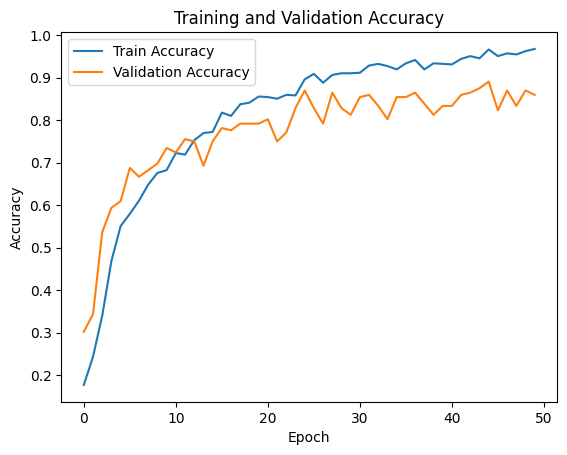

8/8 [==============================] - 2s 239ms/step - loss: 197.0768 - accuracy: 0.2583
Test loss: 197.077
Test accuracy: 0.258
Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 16.6929 - accuracy: 0.1406
Epoch 1: val_accuracy improved from -inf to 0.30208, saving model to ./Models\piczak_cnn_2015.h5
24/24 [==============================] - 90s 4s/step - loss: 16.6929 - accuracy: 0.1406 - val_loss: 16.4031 - val_accuracy: 0.3021
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 16.4301 - accuracy: 0.2448
Epoch 2: val_accuracy did not improve from 0.30208
24/24 [==============================] - 81s 3s/step - loss: 16.4301 - accuracy: 0.2448 - val_loss: 16.3235 - val_accuracy: 0.2031
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 16.2716 - accuracy: 0.2617
Epoch 3: val_accuracy improved from 0.30208 to 0.42708, saving model to ./Models\piczak_cnn_2015.h5
24/24 [==============================] - 82s 3s/step - loss: 16.2716 - accur

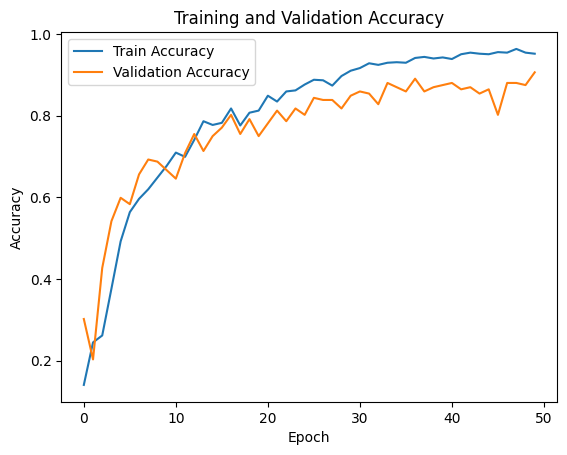

8/8 [==============================] - 2s 251ms/step - loss: 225.9756 - accuracy: 0.2583
Test loss: 225.976
Test accuracy: 0.258
1h 7min 12s ± 20.6 s per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [7]:
%timeit -n 1 -r 2 pipeline_train()

In [ ]:
# Testing
# pipeline_predict('./Datasets/ESC-10/001 - Dog bark/1-100032-A.ogg')